In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import wandb

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.utils import data


import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import functools
from tqdm import tqdm
from datetime import datetime
import numpy as np
from core.datasets.vqa_motion_dataset import VQMotionDataset,DATALoader,VQVarLenMotionDataset,MotionCollator,VQFullMotionDataset
from einops import rearrange, reduce, pack, unpack
import librosa

In [4]:
from utils.motion_process import recover_from_ric
import visualize.plot_3d_global as plot_3d
from glob import glob
def to_xyz(motion, mean ,std , j = 22):
    motion_xyz = recover_from_ric(motion.cpu().float()*std+mean, j)
    motion_xyz = motion_xyz.reshape(motion.shape[0],-1, j, 3)
    return motion_xyz

            
def sample_render(motion_xyz , name , save_path):
    print(f"render start")
    
    gt_pose_vis = plot_3d.draw_to_batch(motion_xyz.numpy(),None, [os.path.join(save_path,name + ".gif")])



In [5]:
from configs.config import cfg, get_cfg_defaults
from core.models.vqvae import VQMotionModel
from core.models.motion_regressor import MotionRegressorModel


cfg_vq = get_cfg_defaults()
cfg_vq.merge_from_file("/srv/scratch/sanisetty3/music_motion/motion_vqvae/configs/var_len_768_768_aist_vq.yaml")




In [11]:
from core.datasets.vqa_motion_dataset import MotionCollatorConditional, TransMotionDatasetConditional,VQMotionDataset,DATALoader,VQVarLenMotionDataset,MotionCollator,VQFullMotionDataset


## VQVAE

In [6]:
vqvae_model = VQMotionModel(cfg_vq.vqvae).eval()
pkg = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/var_len/vq_768_768_mix/vqvae_motion_best_fid.pt", map_location = 'cpu')
print(pkg["steps"])
vqvae_model.load_state_dict(pkg["model"])
vqvae_model =vqvae_model.cuda()


tensor([295000.])


In [54]:
aist_vq_ds = VQFullMotionDataset("aist", split = "train" , data_root = "/srv/scratch/sanisetty3/music_motion/AIST" , window_size = 200)
aist_vq_loader = DATALoader(aist_vq_ds,1,collate_fn=None)

100%|██████████| 1910/1910 [00:01<00:00, 1246.68it/s]

Total number of motions 1910


## Trans Model

In [7]:
from configs.config import cfg, get_cfg_defaults
from core.models.motion_regressor import MotionRegressorModel


cfg_trans = get_cfg_defaults()
cfg_trans.merge_from_file("/srv/scratch/sanisetty3/music_motion/motion_vqvae/configs/var_len_768_768_aist.yaml")



In [9]:
trans_model = MotionRegressorModel(args = cfg_trans.motion_trans,pad_value=1025 ).eval()
pkg_trans = torch.load(f"/srv/scratch/sanisetty3/music_motion/motion_vqvae/checkpoints/generator/var_len/trans_768_768_albi_aist/trans_motion_best_fid.pt", map_location = 'cpu')
print(pkg_trans["steps"])
trans_model.load_state_dict(pkg_trans["model"])
trans_model =trans_model.cuda()


tensor([195000.])


In [33]:
aist_tran_ds = TransMotionDatasetConditional("aist", split = "test",data_root = "/srv/scratch/sanisetty3/music_motion/AIST" , datafolder="joint_indices_max_400",  musicfolder = "audio_features",window_size = 400)
collate_fn2 = MotionCollatorConditional(dataset_name = "aist" , clip_model=None, bos = 1024, pad = 1025, eos = 1026)

aist_tran_loader = DATALoader(aist_tran_ds,1,collate_fn=collate_fn2 , shuffle = False)


100%|██████████| 40/40 [00:00<00:00, 1021.97it/s]

Total number of motions 40


## TSNE

In [48]:
import plotly
import plotly.express as px
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

In [32]:
genre_dict = {
    "mBR" : "Break",
    "mPO" : "Pop",
    "mLO" : "Lock",
    "mMH" : "Middle Hip-hop",
    "mLH" : "LA style Hip-hop",
    "mHO" : "House",    
    "mWA" : "Waack",
    "mKR" : "Krump",
    "mJS" : "Street Jazz",
    "mJB" : "Ballet Jazz",
}

joint_index_genre_mapping = {
    "Break":[],
    "Pop":[],
    "Lock":[],
    "Middle Hip-hop":[],
    "LA style Hip-hop":[],
    "House":[],    
    "Waack":[],
    "Krump":[],
    "Street Jazz":[],
    "Ballet Jazz":[],
}

In [55]:
y = []
X = []

In [56]:
vqvae_model.eval()
val_loss_ae = {}
all_loss = 0.
indice_freq = np.zeros(1024)

print(f"validation start")

with torch.no_grad():

    for batch in tqdm((aist_vq_loader), position=0, leave=True):


        gt_motion = batch["motion"][0]
        genre = genre_dict[batch["names"][0].split("_")[-2][:3]]
        joint_index_genre_mapping[genre].append(gt_motion) 
        X.append(gt_motion)
        y.append(genre)

#         pred_motion , indices, commit_loss = vqvae_model(gt_motion.cuda())
#         indice_freq[list(indices.detach().cpu().numpy()[0])] +=1

           



validation start


100%|██████████| 1910/1910 [00:00<00:00, 3969.67it/s]


In [60]:
X_embedded = TSNE(n_components=2, learning_rate='auto' , n_iter = 10000).fit_transform(np.stack(X).reshape(len(X),-1))


/srv/share2/sanisetty3/miniconda3/envs/ai-choreo/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


<AxesSubplot:>

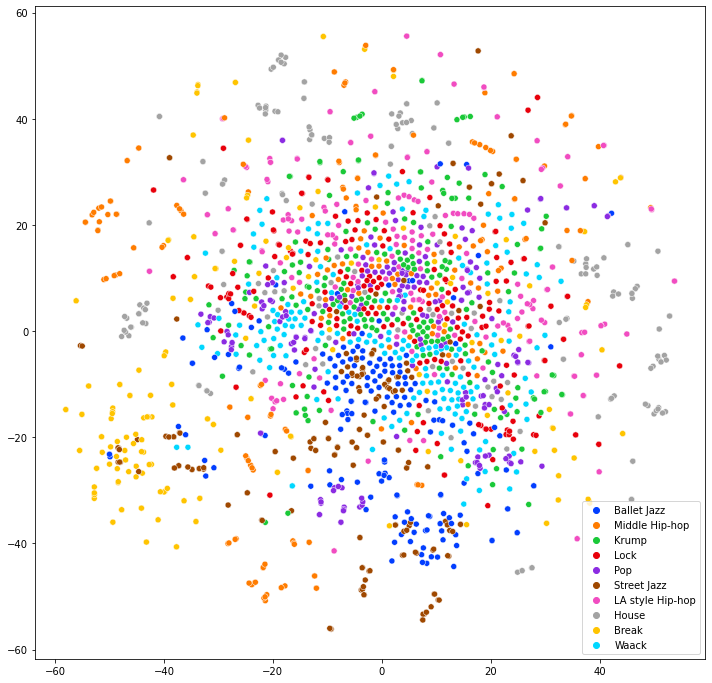

In [63]:
plt.figure(figsize = (12,12))
sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = y, palette = "bright" , legend = True)

## SMPL

In [74]:
from render_final import render, saveSMPL
from core.datasets.vqa_motion_dataset import TransMotionDatasetConditionalFull

In [66]:
train_ds = TransMotionDatasetConditionalFull("aist", split = "test",data_root = "/srv/scratch/sanisetty3/music_motion/AIST" , datafolder="joint_indices_max_400", window_size = -1)


100%|██████████| 40/40 [00:00<00:00, 1081.49it/s]

Total number of motions 40


In [67]:
motions_list = glob("/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/generator/var_len/trans_768_768_albi_aist/*.npy")

In [68]:
name =os.path.basename( motions_list[2]).split(".")[0]
motion = np.load(motions_list[0])

In [72]:
motion_xyz = to_xyz(torch.Tensor(motion) , mean=train_ds.mean , std = train_ds.std)

In [ ]:
for i in tqdm(motions_list):
    name =os.path.basename(i).split(".")[0]
    print(name)
    motion = np.load(i)
    motion_xyz = to_xyz(torch.Tensor(motion) , mean=train_ds.mean , std = train_ds.std)
    saveSMPL(motion_xyz[0].numpy(), outdir="/srv/scratch/sanisetty3/music_motion/motion_vqvae/evals/generator/var_len/trans_768_768_albi_aist/SMPL", name=name, pred=True)

  0%|          | 0/60 [00:00<?, ?it/s]

mWA3
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.


  2%|▏         | 1/60 [02:45<2:42:19, 165.08s/it]

torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])
torch.Size([1, 6890, 3, 401])
mWA4
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


  3%|▎         | 2/60 [06:00<2:56:42, 182.80s/it]

torch.Size([1, 6890, 3, 401])
mHO4
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.


  5%|▌         | 3/60 [08:50<2:48:15, 177.11s/it]

torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])
torch.Size([1, 6890, 3, 401])
mHO3
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


  7%|▋         | 4/60 [11:25<2:37:06, 168.32s/it]

torch.Size([1, 6890, 3, 401])
mMH3
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


  8%|▊         | 5/60 [14:18<2:35:42, 169.87s/it]

torch.Size([1, 6890, 3, 401])
mJB4
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


 10%|█         | 6/60 [17:13<2:34:43, 171.92s/it]

torch.Size([1, 6890, 3, 401])
mPO3
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


 12%|█▏        | 7/60 [19:48<2:26:41, 166.07s/it]

torch.Size([1, 6890, 3, 401])
mPO4
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.


 13%|█▎        | 8/60 [22:45<2:27:10, 169.81s/it]

torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])
torch.Size([1, 6890, 3, 401])
mJB3
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


 15%|█▌        | 9/60 [25:10<2:17:35, 161.87s/it]

torch.Size([1, 6890, 3, 401])
mMH4
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.


 17%|█▋        | 10/60 [28:04<2:17:56, 165.54s/it]

torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])
torch.Size([1, 6890, 3, 401])
mJS4
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


 18%|█▊        | 11/60 [30:34<2:11:32, 161.06s/it]

torch.Size([1, 6890, 3, 401])
mBR0
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.


 20%|██        | 12/60 [33:13<2:08:21, 160.45s/it]

torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])
torch.Size([1, 6890, 3, 401])
mJS3
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.


 22%|██▏       | 13/60 [35:59<2:06:48, 161.89s/it]

torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])
torch.Size([1, 6890, 3, 401])
mLH3
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


 23%|██▎       | 14/60 [38:39<2:03:45, 161.43s/it]

torch.Size([1, 6890, 3, 401])
mLH4
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


 25%|██▌       | 15/60 [40:40<1:52:01, 149.36s/it]

torch.Size([1, 6890, 3, 401])
mKR2
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.


 27%|██▋       | 16/60 [43:03<1:48:00, 147.28s/it]

torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])
torch.Size([1, 6890, 3, 401])
mLO1
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])
torch.Size([1, 6890, 3, 401])


 28%|██▊       | 17/60 [45:09<1:40:57, 140.88s/it]

mKR5
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.
torch.Size([1, 25, 6, 401]) dict_keys(['pose', 'betas', 'cam'])


 30%|███       | 18/60 [47:56<1:44:03, 148.66s/it]

torch.Size([1, 6890, 3, 401])
mPO5
cuda:0
./body_models/
Running SMPLify, it may take a few minutes.


cuda:0
./body_models/
torch.Size([1, 6890, 3, 401])
0


ValueError: row index exceeds matrix dimensions